In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [5]:
# Define data transformations for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ]),
}

In [18]:
# Specify the directory containing the data
data_dir = 'C:\\Users\KAVYA\\Desktop\\project\\makeup-product-recommender-main\\skindata20'

In [19]:
# Load all data from the directory
all_data = datasets.ImageFolder(data_dir, data_transforms['train'])

In [20]:
# Calculate the size of training and validation datasets
total_size = len(all_data)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

In [21]:
# Split the data into training and validation sets
train_data, val_data = torch.utils.data.random_split(all_data, [train_size, val_size])

In [22]:
# Create data loaders for training and validation
dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4),
}

In [23]:
# Store the sizes of the datasets
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data),
}

In [25]:
# Get the class names
class_names = all_data.classes

In [29]:
# Function to plot training history
def plot_training_history(train_loss, val_loss, train_acc, val_acc, output_dir):
    train_loss_cpu = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
    val_loss_cpu = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in val_loss]
    train_acc_cpu = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in train_acc]
    val_acc_cpu = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in val_acc]

    # Function to plot graphs
    def plot(title, ylabel, train_data, val_data, filename):
        plt.figure(figsize=(10, 5))
        plt.plot(train_data, label='Training')
        plt.plot(val_data, label='Validation')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.legend()
        plt.savefig(os.path.join(output_dir, filename))
        plt.show()

    # Plot Loss
    plot('Training and Validation Loss', 'Loss', train_loss_cpu, val_loss_cpu, 'loss_plot.png')

    # Plot Accuracy
    plot('Training and Validation Accuracy', 'Accuracy', train_acc_cpu, val_acc_cpu, 'accuracy_plot.png')


In [30]:
# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        # Save the initial model parameters
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Lists to store training history
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass and optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Save history for plotting
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc)
                else:
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc)

                # Deep copy the model if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            if epoch % 10 == 0:
                last_model_params_path = os.path.join(tempdir, f'last_model_params_epoch_{epoch}.pt')
                torch.save(model.state_dict(), last_model_params_path)
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # Plot training history
        plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history, tempdir)

    return model

In [31]:
# Load pre-trained MobileNetV2 model
model_ft = models.mobilenet_v2(pretrained=True)

c:\Users\KAVYA\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KAVYA\anaconda3\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\KAVYA/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%


In [32]:
# Modify the classifier to fit the number of classes (e.g., 4 classes for skin tone)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, 50),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(50, 4)
)

In [33]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [34]:
# Train the model on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

Training complete in 0m 0s
Best val Acc: 0.0000


C:\Users\KAVYA\AppData\Local\Temp\ipykernel_3104\1235629799.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


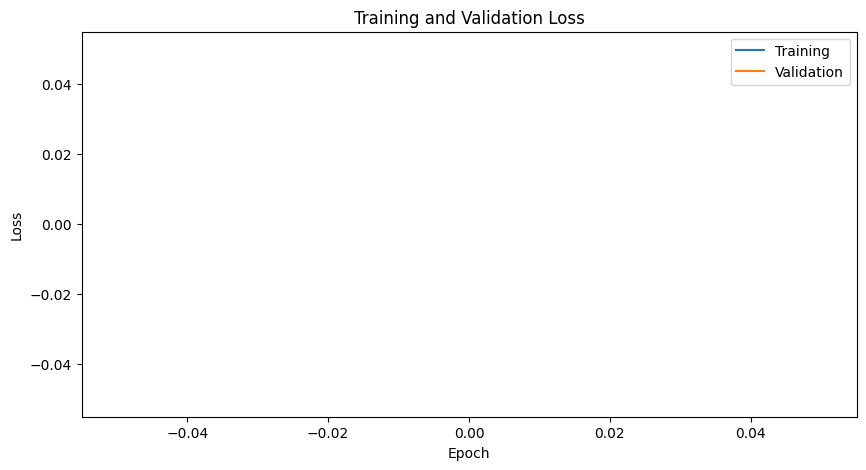

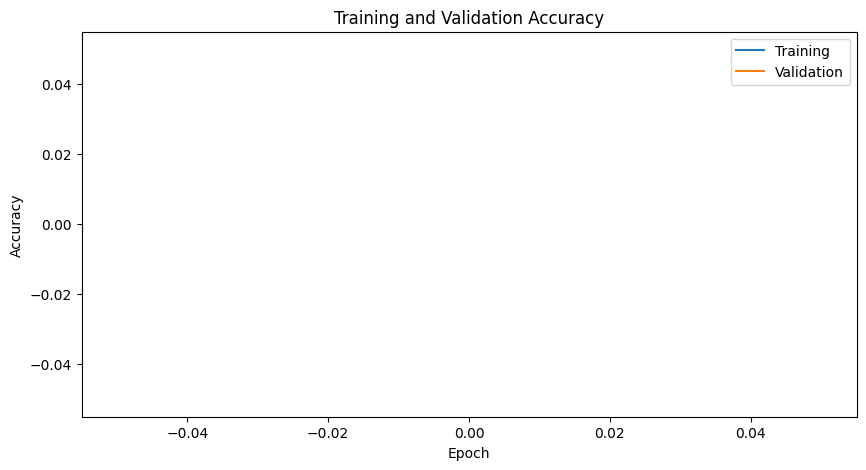

In [40]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=0)

In [41]:
# Function to predict skin tone of images in a folder
def predict(model, test_folder, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for image_path in os.listdir(test_folder):
            image_path = os.path.join(test_folder, image_path)
            image = Image.open(image_path)
            transform = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            image = transform(image).unsqueeze(0).to(device)
            output = model(image)
            _, predicted = torch.max(output.data, 1)
            predictions.append(predicted.item())
    return predictions

In [42]:
torch.save(model_ft.state_dict(), 'trainedmodel.pth')

In [46]:
# Make predictions on test images
test_folder = 'C:\\Users\\KAVYA\\Desktop\\project\\makeup-product-recommender-main\\skindata20\\dark\\.ipynb_checkpoints'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
predictions = predict(model_ft, test_folder, device)

In [47]:
# Print the predictions
for i, prediction in enumerate(predictions):
    print(f"Image {i+1}: {class_names[prediction]}")

Image 1: light


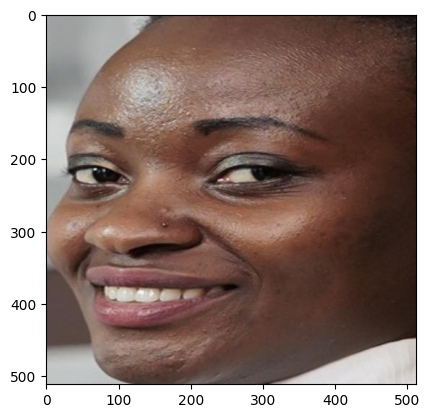

In [48]:
#  show 1st image in test_folder

import matplotlib.pyplot as plt
from PIL import Image

# Get the first image from the test folder
first_image_path = os.path.join(test_folder, os.listdir(test_folder)[0])

# Load the image
image = Image.open(first_image_path)

# Display the image
plt.imshow(image)
plt.show()


In [49]:
#  predict skin tone of 1st image in test_folder using above model

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0).to(device)

# Make prediction
model_ft.eval()
with torch.no_grad():
    predictions = model_ft(image_tensor)

# Get the predicted class
predicted_class_index = predictions.argmax(dim=1)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print(f"Predicted skin tone: {predicted_class}")

Predicted skin tone: light


--------------------

In [50]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [51]:
data = {
    "Skin Tone": ["light", "mid_light", "mid_dark", "dark"],
    "Lipstick": ["Nude Beach, Peachy Keen, Vanilla Cream", "Coral Crush, Peach Fuzz, Cinnamon Spice", "Mocha Madness, Toasted Almond, Cocoa Butter", "Plum Royale, Rich Raisin, Deep Burgundy"],
    "Compact": ["Fair Porcelain, Light Ivory, Alabaster Glow", "Natural Buff, Buff Beige, Medium Light", "Caramel, Medium Tan, Warm Beige", "Cocoa, Deep Bronze, Dark Walnut"],
    "Blush": ["Soft Rose, Petal Pink, Cotton Candy", "Peachy Glow, Warm Apricot, Coralista", "Terracotta, Spiced Coral, Raspberry Rush", "Berry Bliss, Rich Spice, Mahogany"],
    "Eyeliner": ["Champagne Shimmer, Pearl, Golden Bronze", "Amber Glow, Toffee, Bronze Beam", "Copper Glow, Mahogany, Espresso", "Black Opal, Onyx, Ebony"]
}

df = pd.DataFrame(data)

In [52]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df["Lipstick"] + ", " + df["Compact"] + ", " + df["Blush"] + ", " + df["Eyeliner"])

In [53]:
# Compute similarity scores
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [54]:
# Function to recommend products based on skin tone
def recommend_products(skin_tone, cosine_sim=cosine_sim):
    idx = df[df["Skin Tone"] == skin_tone].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:2]  
    product_indices = [i[0] for i in sim_scores]
    return df["Lipstick"][product_indices], df["Compact"][product_indices], df["Blush"][product_indices], df["Eyeliner"][product_indices]

In [55]:
skin_tone = predicted_class
lipsticks, compacts, blushes, eyeliners = recommend_products(skin_tone)
print(f"\tFor skin tone : {skin_tone}")
print("Recommended Lipstick Shades:\n", lipsticks)
print("Recommended Compact Shades:\n", compacts)
print("Recommended Blush Shades:\n", blushes)
print("Recommended Eyeliner Shades:\n", eyeliners)

	For skin tone : light
Recommended Lipstick Shades:
 1    Coral Crush, Peach Fuzz, Cinnamon Spice
Name: Lipstick, dtype: object
Recommended Compact Shades:
 1    Natural Buff, Buff Beige, Medium Light
Name: Compact, dtype: object
Recommended Blush Shades:
 1    Peachy Glow, Warm Apricot, Coralista
Name: Blush, dtype: object
Recommended Eyeliner Shades:
 1    Amber Glow, Toffee, Bronze Beam
Name: Eyeliner, dtype: object
